In [477]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pickle
import operator
from collections import OrderedDict
%matplotlib nbagg

### Open and prepare dataset:

In [2]:
df = pd.read_csv('upwork_df.csv', index_col=0)
df['time'] = df['time'].apply(pd.to_datetime)
df = df.dropna(subset=['title', 'desc']).reset_index(drop=True)

In [3]:
df.head()

,budget,desc,duration,key,level,skills,time,title,type
0,20.0,hello need someone who can help scrape mails f...,NaN,01241f8bc8bbbb99bf,entry,data_scraping microsoft_excel microsoft_office...,2018-01-06 09:07:03,mail scraping,fixed
1,NaN,need develop app ios andriod for blockcian and...,"1 to 3 months, 30+ hrs/week",01eb1de51bfccf3bca,expert,android_app_development blockchain ios_develop...,2018-01-06 08:47:35,cryptocurrency app,hourly
2,80.0,need matlab program which can detect medals ta...,NaN,01a1df3c46e33e463e,entry,NaN,2018-01-06 07:21:31,object recognition using matlab,fixed
3,40.0,hello seasoning and spice company that need re...,NaN,01e3e967e1a881849b,expert,NaN,2018-01-06 06:59:26,restaurant data needed,fixed
4,500.0,looking for experienced developer who has crea...,NaN,014202d8654f9d6de3,intermediate,website_development,2018-01-06 06:36:30,web scraper and analysis algo reddit twitter m...,fixed


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 9 columns):
budget      794 non-null float64
desc        2027 non-null object
duration    1111 non-null object
key         2027 non-null object
level       2027 non-null object
skills      1534 non-null object
time        2027 non-null datetime64[ns]
title       2027 non-null object
type        2027 non-null object
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 142.6+ KB


### Similarity by "skills":

In [448]:
def get_skills_dict(df):
    skills = {}
    for row in df['skills'].values.tolist():
        if type(row) != float:
            content = row.split(' ')
            for tag in content:
                if tag not in skills.keys():
                    skills[tag] = 0
                skills[tag] += 1
    return skills

In [411]:
skills = get_skills_dict(df)

In [412]:
pickle.dump(skills, open('./data/skills.pickle.dat', 'wb'))

In [413]:
sorted(skills.items(), key=operator.itemgetter(1), reverse=True)[:20]

[('microsoft_excel', 248),
 ('python', 234),
 ('data_mining', 195),
 ('web_scraping', 183),
 ('data_science', 172),
 ('machine_learning', 168),
 ('data_scraping', 166),
 ('data_analytics', 156),
 ('statistics', 120),
 ('data_entry', 116),
 ('r', 80),
 ('internet_research', 79),
 ('excel_vba', 74),
 ('artificial_intelligence', 66),
 ('sql', 62),
 ('quantitative_analysis', 60),
 ('data_visualization', 55),
 ('mathematics', 54),
 ('tableau_software', 52),
 ('c_', 52)]

In [470]:
class TagSimilarity:
    
    def __init__(self, skills, df):
        self.skills = skills
        self.df = df
                
    def get(self, row, n=10):
        row = set(row.split(' '))
        sims, absolute = [], []
        for i, skill_set in enumerate(self.df['skills']):
            if type(skill_set) != float:
                skill_set = set(skill_set.split(' '))
                intersect = len(skill_set.intersection(row))
                if intersect == len(row) == len(skill_set):
                    absolute.append(i)
                elif intersect > 0:
                    sims.append((i, intersect))
        sims = list(dict(sorted(sims, key=operator.itemgetter(1), reverse=True)[:n-len(absolute)]).keys())
        indexes = absolute + sims
        urls = ['https://www.upwork.com/job/~%s/' % i for i in self.df.loc[indexes]['key'].values.tolist()]
        return indexes, urls
    
    def save(self):
        pickle.dump(self, open('./data/similarity.pickle.dat', 'wb'))
        
    @classmethod
    def load(self):
        return pickle.load(open('./data/similarity.pickle.dat', 'rb'))

In [460]:
sim = TagSimilarity(skills, df)

In [483]:
lens, count = [], {}
for skill_set in df['skills']:
    if type(skill_set) != float:
        length = len(skill_set.split(' '))
        if length not in count.keys():
            count[length] = 0
        count[length] += 1
        lens.append(length)

In [476]:
OrderedDict(sorted(count.items(), key=operator.itemgetter(1), reverse=True))

OrderedDict([(2, 316),
             (1, 310),
             (3, 307),
             (4, 207),
             (5, 158),
             (6, 80),
             (7, 48),
             (8, 29),
             (9, 22),
             (10, 16),
             (14, 10),
             (19, 8),
             (11, 6),
             (12, 5),
             (17, 3),
             (13, 2),
             (15, 2),
             (16, 1),
             (58, 1),
             (28, 1),
             (21, 1),
             (23, 1)])

<IPython.core.display.Javascript object>


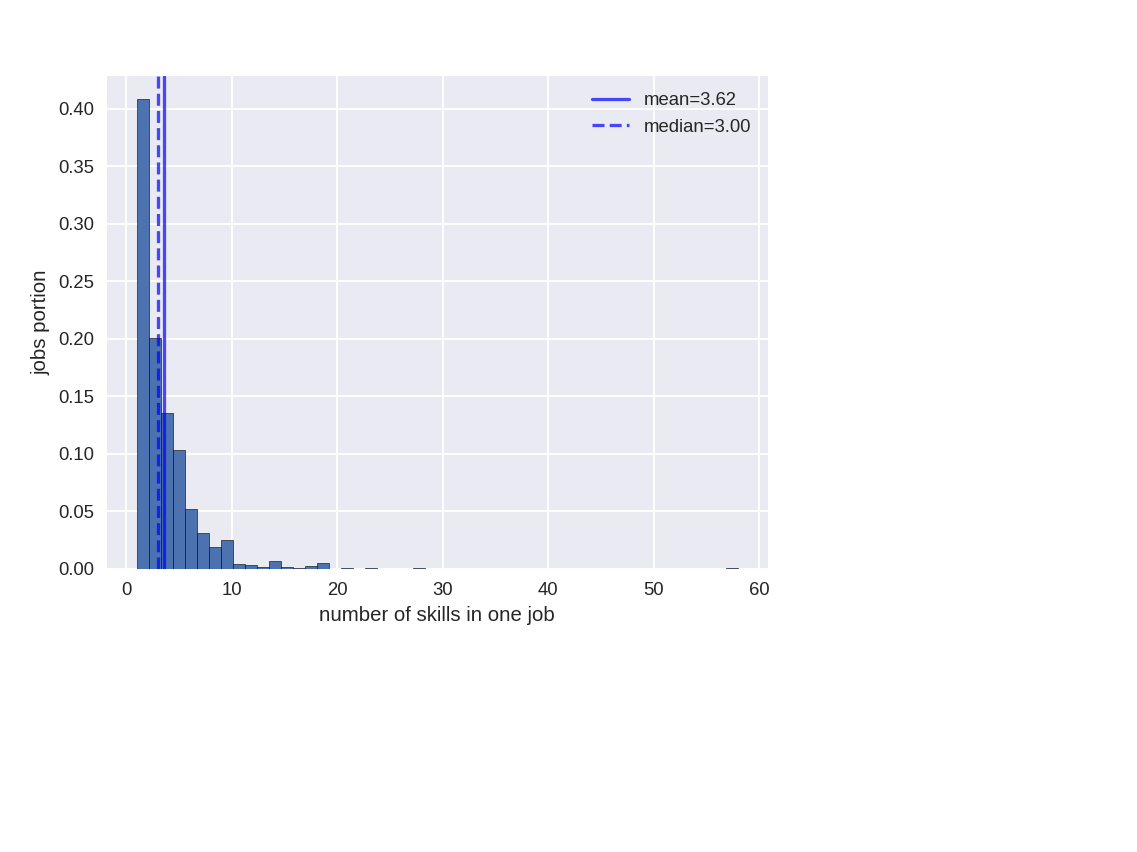

In [484]:
weights = np.ones_like(lens)/float(len(lens))
plt.hist(lens, weights=weights, bins=50, edgecolor='black')
plt.axvline(np.mean(lens), color='b', label='mean=%.2f' % np.mean(lens), alpha=0.7)
plt.axvline(np.median(lens), color='b', linestyle='--', label='median=%.2f' % np.median(lens), alpha=0.7)
plt.xlabel('number of skills in one job')
plt.ylabel('jobs portion')
plt.legend(loc='best')
plt.show()

#### Test:

In [249]:
sim = TagSimilarity.load()

In [461]:
n = 120
closest_id, urls = sim.get(df.loc[n]['skills'])

In [467]:
closest_id

[120, 432, 885, 1140, 1357, 1767, 1820, 44, 93, 185]

In [466]:
for url in urls:
    print(url)

https://www.upwork.com/job/~018df89499d4db2d32/
https://www.upwork.com/job/~01711a487c4a6d4936/
https://www.upwork.com/job/~016d15939f43101e73/
https://www.upwork.com/job/~01a8d4b183cd549a80/
https://www.upwork.com/job/~01f41ceecd3ca783d1/
https://www.upwork.com/job/~01ac4758a65ff861b9/
https://www.upwork.com/job/~01dd9f940db6f832f0/
https://www.upwork.com/job/~012508c011b1fb65d6/
https://www.upwork.com/job/~01a8da36279b62b73a/
https://www.upwork.com/job/~01028b26060360ab9d/


In [468]:
df.loc[n]['skills']

'business_analysis business_modeling investigative_reporting market_research operations_management'

In [469]:
df.loc[closest_id]['skills'].values.tolist()

['business_analysis business_modeling investigative_reporting market_research operations_management',
 'business_analysis business_coaching business_modeling',
 'business_analysis business_consulting business_development business_management business_modeling business_planning business_valuation business_writing',
 'business_analysis business_modeling internet_research seo_audit',
 'accounting business_analysis business_modeling business_planning financial_accounting financial_analysis financial_management financial_modeling',
 'business_analysis market_research marketing_strategy',
 'analytics business_analysis business_mathematics data_analytics data_science lean_consulting lean_manufacturing mathematics operating_systems_development operations_management operations_research quantitative_analysis six_sigma statistical_computing statistics',
 'data_entry market_research microsoft_excel',
 'business_analysis data_entry economic_analysis mechanical_engineering writing',
 'business_analys

### Descriptions to LSI vectors:

In [62]:
from langdetect import *
import nltk
from gensim.utils import deaccent
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, lsimodel
from gensim.similarities.docsim import Similarity
#nltk.download('wordnet')
#nltk.download('stopwords')

from collections import OrderedDict
import operator
import pickle

class getTokens:
    
    def __init__(self, garbage=['hello', 'hi', 'need', 'help', 'com', 'http', 'please', 'someone', 'etc', 'www']):
        self.tokenizer = nltk.RegexpTokenizer('\w+')        
        self.lmtzr = nltk.stem.wordnet.WordNetLemmatizer()
        self.garbage = set(garbage)
        self.iso_639_1 = {
            'da':'danish',
            'nl':'dutch',
            'en':'english',
            'fi':'finnish',
            'fr':'french',
            'de':'german',
            'hu':'hungarian',
            'it':'italian',
            'kk':'kazakh',
            'no':'norwegian',
            'pt':'portuguese',
            'ru':'russian',
            'es':'spanish',
            'sv':'swedish',
            'tr':'turkish'
        }
    
    def transform(self, text):
        try:
            lang = detect(text)
            self.garbage.update(nltk.corpus.stopwords.words(self.iso_639_1[lang]))
        except:
            pass
        text = self.tokenizer.tokenize(text)
        text = [self.lmtzr.lemmatize(deaccent(word.lower())) for word in text]
        text = [word for word in text if len(word) > 2 and word not in self.garbage]
        return text
    
    def get(self, texts):
        if type(texts) == str:
            yield self.transform(texts)
        else:
            for text in texts:
                yield self.transform(text)
                
class LSI:
    
    @classmethod
    def train(self, corpus):
        self.bigram_phrases = Phrases(corpus)
        self.bigram = Phraser(self.bigram_phrases)
        self.trigram_phrases = Phrases(self.bigram[corpus])
        self.trigram = Phraser(self.trigram_phrases)

        self.dictionary = Dictionary(self.trigram[self.bigram[corpus]])
        self.dictionary.filter_extremes(no_below=2, no_above=0.8, keep_n=None)
        self.dictionary.compactify()

        self.tfidf = TfidfModel(dictionary=self.dictionary)
        corpus_tfidf = self.tfidf[[self.dictionary.doc2bow(self.trigram[self.bigram[text]]) for text in corpus]]

        self.lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=self.dictionary, num_topics=50)
        
        self.dist = Similarity('./data/', self.lsi[corpus_tfidf],
                               (self.lsi.projection.s).shape[0], num_best=None,
                               chunksize=256, shardsize=32768, norm='l1')
        return self
        
    @classmethod
    def transform(self, doc):
        return np.array(self.lsi[self.tfidf[self.dictionary.doc2bow(self.trigram[self.bigram[doc]])]])[:, 1][:, np.newaxis]
    
    @classmethod
    def get_dists(self, doc):
        self.dist.num_best = 10
        return OrderedDict(self.dist[self.lsi[self.tfidf[self.dictionary.doc2bow(self.trigram[self.bigram[doc]])]]])
        
    @classmethod
    def evaluate(self, text):
        self.bigram_phrases.add_vocab(text)
        self.bigram = Phraser(self.bigram_phrases)
        self.trigram_phrases.add_vocab(self.bigram[text])
        self.trigram = Phraser(self.trigram_phrases)
        text = self.trigram[self.bigram[text]]
        
        self.dictionary.add_documents([text], prune_at=None)
        add = self.dictionary.doc2bow(text)
        self.tfidf = TfidfModel(dictionary=self.dictionary)
        self.dist.add_documents(self.lsi[self.tfidf[[add]]])

    @classmethod
    def save(self):
        pickle.dump(self, open('./data/LSI_model.pickle.dat', 'wb'))
        
    @classmethod
    def load(self):
        return pickle.load(open('./data/LSI_model.pickle.dat', 'rb'))

In [6]:
tokens = getTokens()
corpus = list(tokens.get(df['desc']))

In [63]:
LSI_model = LSI.train(corpus[:-100])

In [64]:
n = -100
similar = LSI_model.get_dists(corpus[n])
print(corpus[n])
df.loc[list(similar.keys())]['desc'].values.tolist()

['salesforce', 'developer', 'know', 'create', 'formula', 'summarize', 'data', 'one', 'line', 'item', 'date', 'report', 'display', 'one', 'line', 'item', 'csv', 'file', 'also', 'csv', 'file', 'automatically', 'sent', 'external', 'ftp', 'site', 'every', 'week', 'salesforce']


['sales rep who trying help customers grow their online business one challenge have that can only help them know what they have their site for brands and what needs their site taken off their site have had many customer sites crawled and able reports that compares their data their site refined data and then can make compelling reports that really show awesome information them how update upgrade their sites few newer customers who want these same reports for which will impress them are using captcha need see there way crawl products that can provide and pull info off the site like category etc pricing description etc would like this built quot ongoing quot crawl possible but can only done manually need know that too bottom line captcha the end all web crawling then will just ask them for reports which will slow down model want actually this before meetings with customers ensure quot top quot them need someone make crawl and then push the results ftp the form csv daily feed url whatever 

In [65]:
LSI_model.evaluate(corpus[-100])

In [66]:
n = -100
similar = LSI_model.get_dists(corpus[n])
print(df.iloc[n]['desc'])
print(corpus[n])
df.loc[list(similar.keys())]['desc'].values.tolist()

need salesforce developer who knows how create formulas summarize all data into one line item and date report and have display one line item the csv file also need the csv file automatically sent external ftp site every week from salesforce
['salesforce', 'developer', 'know', 'create', 'formula', 'summarize', 'data', 'one', 'line', 'item', 'date', 'report', 'display', 'one', 'line', 'item', 'csv', 'file', 'also', 'csv', 'file', 'automatically', 'sent', 'external', 'ftp', 'site', 'every', 'week', 'salesforce']


['need salesforce developer who knows how create formulas summarize all data into one line item and date report and have display one line item the csv file also need the csv file automatically sent external ftp site every week from salesforce',
 'sales rep who trying help customers grow their online business one challenge have that can only help them know what they have their site for brands and what needs their site taken off their site have had many customer sites crawled and able reports that compares their data their site refined data and then can make compelling reports that really show awesome information them how update upgrade their sites few newer customers who want these same reports for which will impress them are using captcha need see there way crawl products that can provide and pull info off the site like category etc pricing description etc would like this built quot ongoing quot crawl possible but can only done manually need know that too bottom line captcha the end al

In [303]:
skills = pickle.load(open('./data/skills.pickle.dat', 'rb'))
sim = TagSimilarity(skills, df.iloc[:-100])
sim.train()

training: 100%|██████████| 1927/1927 [15:23<00:00,  1.89it/s]


In [304]:
closest_id = sim.get(df.iloc[-100]['skills'])
print('Intersection:', sim.df_new.iloc[closest_id].sum(), 'tags')

prediction: 100%|██████████| 1927/1927 [00:03<00:00, 494.64it/s]

Intersection: 4 tags


In [305]:
df.loc[0]['skills'], df.loc[closest_id]['skills']

('data_scraping microsoft_excel microsoft_office web_scraping',
 'data_scraping microsoft_excel microsoft_office web_scraping')

In [263]:
sorted(LSI_model.trigram_phrases.vocab.items(), key=operator.itemgetter(1), reverse=True)[:100]

[(b'data', 1390),
 (b'looking', 898),
 (b'project', 540),
 (b'work', 518),
 (b'experience', 389),
 (b'website', 367),
 (b'quot', 366),
 (b'using', 355),
 (b'company', 332),
 (b'information', 322),
 (b'one', 316),
 (b'use', 315),
 (b'would', 311),
 (b'create', 299),
 (b'time', 290),
 (b'report', 287),
 (b'list', 286),
 (b'based', 284),
 (b'job', 281),
 (b'business', 257),
 (b'u2022', 254),
 (b'product', 252),
 (b'must', 249),
 (b'also', 244),
 (b'able', 240),
 (b'excel', 239),
 (b'analysis', 236),
 (b'get', 230),
 (b'provide', 227),
 (b'expert', 224),
 (b'user', 223),
 (b'email', 223),
 (b'name', 220),
 (b'would_like', 219),
 (b'find', 204),
 (b'developer', 200),
 (b'like', 199),
 (b'model', 198),
 (b'amp', 195),
 (b'code', 193),
 (b'database', 192),
 (b'example', 191),
 (b'file', 190),
 (b'want', 189),
 (b'new', 188),
 (b'web', 180),
 (b'number', 177),
 (b'task', 175),
 (b'software', 175),
 (b'contact', 174),
 (b'system', 173),
 (b'tool', 171),
 (b'detail', 168),
 (b'person', 168),
 (b

In [10]:
lsi_out = np.hstack(([np.array(lsimodel[tfidf[dictionary.doc2bow(trigram[bigram[doc]])]])[:, 1][:, np.newaxis] for doc in corpus])).T
lsi_out = pd.DataFrame(lsi_out, columns=np.arange(lsi_out.shape[1]), index=np.arange(lsi_out.shape[0]))
lsi_out['key'] = df['key']

In [11]:
lsi_out.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,key
0,0.064816,0.047967,0.066147,-0.051352,0.023885,-0.055564,0.059618,0.016019,0.000054,-0.005824,...,-0.030594,-0.015727,0.011472,-0.009079,-0.032868,0.024335,-0.032774,0.050415,0.076195,01241f8bc8bbbb99bf
1,0.124066,0.013533,-0.037175,0.040013,-0.014932,0.022915,0.025015,-0.044867,0.001521,0.022750,...,-0.026130,-0.068150,-0.013320,-0.080208,0.059573,-0.034923,-0.018053,0.024313,0.096276,01eb1de51bfccf3bca
2,0.065662,0.012807,0.011873,0.037718,-0.030793,0.079904,-0.040109,-0.054617,0.007146,-0.056265,...,0.011256,-0.056856,0.034683,0.107635,-0.079738,0.101469,-0.044983,-0.070234,0.050411,01a1df3c46e33e463e
3,0.103748,0.047288,0.061735,-0.053563,0.028122,-0.050515,0.069982,0.044824,-0.006481,-0.055369,...,0.026882,0.006740,0.006352,-0.048491,0.028461,-0.032681,0.019144,0.013328,0.082337,01e3e967e1a881849b
4,0.178423,0.057520,0.054340,-0.000951,0.002812,0.009559,-0.037251,-0.039737,0.007982,-0.012265,...,-0.013474,0.009849,-0.009438,-0.006973,0.042904,-0.010792,-0.059362,0.011029,-0.025039,014202d8654f9d6de3


In [12]:
from sklearn.cluster import AffinityPropagation, MeanShift, KMeans
from sklearn.manifold import TSNE

In [22]:
reduced = TSNE(n_components=2).fit_transform(lsi_out[list(range(50))])

In [152]:
class clustering:
    
    @staticmethod
    def mean_shift(data, bandwidth=None):
        ms = MeanShift(bandwidth=bandwidth, seeds=None, bin_seeding=True,
                       min_bin_freq=1, cluster_all=True, n_jobs=-1).fit(data)
        return {'labels': ms.labels_, 'cluster_centers': ms.cluster_centers_}
    
    @staticmethod
    def k_means(data, n_clusters=8):
        km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, 
                    tol=0.0001, precompute_distances='auto', verbose=0, 
                    random_state=None, copy_x=True, n_jobs=-1, algorithm='auto').fit(data)
        return {'cluster_centers': km.cluster_centers_, 'labels': km.predict(data)}

In [167]:
#lsi_out[list(range(50))], reduced

#result = clustering.k_means(reduced, n_clusters=5)
result = clustering.mean_shift(reduced, bandwidth=3.8)

labels = np.unique(result['labels'])
print(len(labels))

12


In [168]:
result['cluster_centers']

array([[ -5.90144281,  13.6992033 ],
       [ -8.97144395,   7.55692177],
       [ -2.26836279,   4.39285686],
       [  4.13836652,   7.5398122 ],
       [  1.45282048,  10.70550445],
       [ -0.89455724,  -0.4769332 ],
       [ -5.51590892,  -7.78351051],
       [ -7.02448974,  -0.68309648],
       [  9.97450461,   4.04464032],
       [-11.69045387,   0.77819772],
       [  6.1762551 ,  -4.19203624],
       [ -7.97876874, -13.47811878]])

<IPython.core.display.Javascript object>


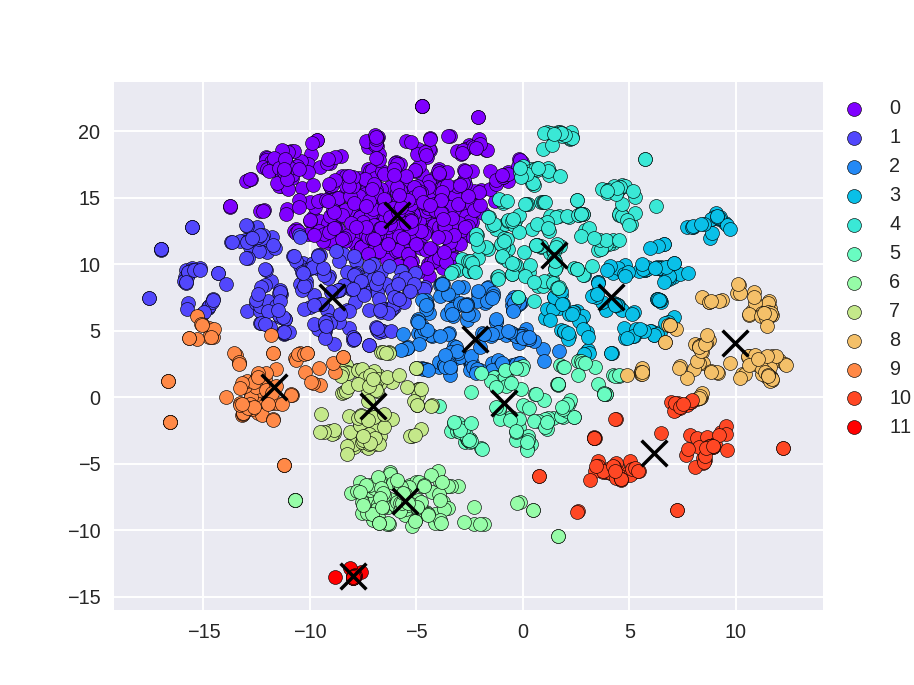

In [169]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
for i in labels:
    plt.scatter(reduced[result['labels'] == i, 0], reduced[result['labels'] == i, 1], color=colors[i], label=i, edgecolor='black')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.scatter(result['cluster_centers'][:, 0], result['cluster_centers'][:, 1], 
            marker='x', s=169, linewidths=3, color='black', zorder=10)
plt.show()

In [170]:
def dist(a, b):
    return np.power((np.power((a[0] - b[:, 0]), 2) + np.power((a[1] - b[:, 1]), 2)), 1./2)

In [171]:
for i in labels:
    tops = np.argsort(dist(result['cluster_centers'][i], reduced))[:10]
    print('cluster #%i:\n' % i, df.loc[tops]['title'].values.tolist(), '\n')

cluster #0:
 ['separate gold plate', 'statistical analysis', 'helps about visual foxpro', 'profs système français création exos videos pour collège lycée sauf maths', 'profs système français création exos videos pour collège lycée sauf maths', 'emgucv', 'informatica and teradata support for long term', 'gis consulting help', 'amplitude optimizely drip marketing professional needed', 'looking email searcher person'] 

cluster #1:
 ['need help deciphering vin numbers for specific reasons for each vehicle manufacturer', 'looking for experienced business analyst help define business model for online startup', 'stretch your imagination and creativity', 'kickstarter data from kaggle com rstudio data analysis', 'studio project', 'machine learning help', 'data scientist', 'data scraping retrieval for website', 'consultant needed for merging apple contacts gmail', 'need programmer finish several mql4 scripts will rehire quality work good'] 

cluster #2:
 ['looking create app which scrapes and p

In [ ]:
#if num_best not None -> distances will be auto-sorted

dist.num_best = 10
dist_sort_ = dist[lsimodel[tfidf[dictionary.doc2bow(trigram[bigram[doc]])]]]
#dist_sort_ = [i for i in dist_sort if i[1] >= 0.4]

%%time

#key words for query

topic_ = lsimodel[tfidf[dictionary.doc2bow(trigram[bigram[doc]])]]
doc_scores = sorted([(topic, abs(score)) for topic, score in topic_],
                    key=operator.itemgetter(1), reverse=True)
for score in doc_scores[0:6]: 
    for word in lsimodel.show_topic(score[0], topn=4):
        print(word[0].replace('_', ' '))